# Named Entity Recognition Using Bi LSTM

## Importing Libraries

In [ ]:
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Activation, BatchNormalization
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.optimizers import SGD, Adam, Ftrl
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from tensorflow.keras import metrics
from matplotlib import pyplot as plt
import numpy as np
import pickle
import time

## Preparing Dataset

### Reading From File

In [2]:
# Loading data with quick preprocessesing steps

def read_file(file_name):

    words = []
    parser = []
    ner = []    
    tokens = []
    pos_tags = []
    ner_tags = []
    
    # Some unnecessary characters to remove from input
    chars = """(),.<>?$#@"!%&*:;'~`^=-_+\|{}[]/"""
    removed = [i for i in chars]
    
    with open(file_name, encoding='utf-8') as f:
        
        for line in f:
            
            # Removing any white spaces
            line = line.rstrip()
            
            if line:
                word, pos_, parser_, ner_ = line.split()
                
                # Checking if special characters occur in input
                if word != "-DOCSTART-" and parser_ not in removed and ner_ not in removed:
                    words.append(word)
                    parser.append(parser_)
                    ner.append(ner_)
            else:
                if words != [] and ner != [] and parser != []:
                    tokens.append(words)
                    pos_tags.append(parser)
                    ner_tags.append(ner)
                    words, parser, ner = [], [], []

    return tokens, pos_tags, ner_tags

### Converting Dataset

In [3]:
# Converting data into better format for training

def convert_data(MAX_LEN, x_train, y_train, all_words, all_tags):
    
    # Finds index of words
    
    temp_all_words = {value: idx + 2 for idx, value in enumerate(all_words)}
    temp_all_words["UNK"] = 1 
    temp_all_words["PAD"] = 0
    
    # Finds index of tags

    temp_all_tags = {value: idx + 1 for idx, value in enumerate(all_tags)}
    temp_all_tags["PAD"] = 0 
    
    X = [[temp_all_words[x] for x in value] for value in x_train] 
    y = [[temp_all_tags[x] for x in value] for value in y_train]

    # Padding X and y train sequences
    
    X_padded = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=0)
    y_padded = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=0)
    
    return X_padded, np.array([to_categorical(idx, num_classes=len(all_tags) + 1) for idx in y_padded])

### Loading Dataset

In [4]:
# Loading dataset using the previously defined auxiliary functions 

def load_dataset():
    
    try:
        X_train, _, y_train = read_file("Data/train.file")
        X_valid, _, y_valid = read_file("Data/valid.file")
        X_test, _, y_test = read_file("Data/test.file")

    except:
        print("An error occured while loading dataset...")

    # Extracting unique words to find max length, number of words and number of tags

    all_words, all_tags = [], []

    for idx in X_train + X_valid + X_test: 
        for x in idx: 
            all_words.append(x)

    for idx in y_train: 
        for x in idx:
            all_tags.append(x)

    all_words = list(set(all_words))
    all_tags = list(set(all_tags))

    MAX_LEN = max([len(x) for x in X_train + X_valid + X_test])
    NUM_WORDS = len(all_words) + 2
    NUM_TAGS = len(all_tags) + 1

    # Converting dataset into better format for training

    X_train, y_train = convert_data(MAX_LEN, X_train, y_train, all_words, all_tags)
    X_valid, y_valid = convert_data(MAX_LEN, X_valid, y_valid, all_words, all_tags)
    X_test, y_test = convert_data(MAX_LEN, X_test, y_test, all_words, all_tags)

    print("\nCorpus\n")
    print("Training set size      :", X_train.shape)
    print("Validation set size    :", X_valid.shape)
    print("Test set size          :", X_test.shape)
    print("\nNumber of unique words :", NUM_WORDS)
    print("Max length of input    :", MAX_LEN)
    print("Number of tags         :", NUM_TAGS)
    
    return all_words, all_tags, X_train, X_valid, X_test, y_train, y_valid, y_test, NUM_WORDS, MAX_LEN, NUM_TAGS

## Creating Model Object

In [5]:
# Creating model object with specified hyperparameters

def bi_lstm(NUM_WORDS, MAX_LEN, NUM_TAGS, learning_rate, weight_decay, dropout_rate):
    
    model = Sequential([
        
        # Embedding layer
        Embedding(input_dim=NUM_WORDS, 
                  output_dim=MAX_LEN, 
                  input_length=MAX_LEN),
        
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Bi LSTM with recurrent dropout 
        Bidirectional(LSTM(units=MAX_LEN,
                           return_sequences=True,
                           recurrent_dropout=0.1)),
        
        # Time distributed layer to run on each token of the sequence (last dense layer)
        TimeDistributed(Dense(units=NUM_TAGS)),
    
        Activation('softmax')

    ])
    
    print("\n\nThe architecture of the network\n")
    model.summary()

    model.compile(optimizer=Adam(learning_rate=learning_rate, decay=weight_decay), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', metrics.Precision, metrics.Recall, metrics.])
    
    return model

## Plotting Loss and Acc

In [6]:
# Plotting accuracy and loss after training

def plot_acc_loss(history):

    # Plotting the training and validation loss

    plt.plot(history['loss'], label='train', marker = 'o')
    plt.plot(history['val_loss'], label='val', marker = 'v')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(len(history['accuracy'])), np.arange(1, len(history['accuracy'])+1))
    plt.show()

    # Plotting the training and validation accuracy

    plt.plot(history['accuracy'], label='train', marker = 'o')
    plt.plot(history['val_accuracy'], label='val', marker = 'v')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(np.arange(len(history['accuracy'])), np.arange(1, len(history['accuracy'])+1))
    plt.show()

    return

## Evaluation on Test Data

In [48]:
# Evaluating model on test data

def evaluate(X_test, y_test, all_tags):
    
    model = load_model("checkpoints/BiLSTM_NER.h5")
    
    test_evaluation = model.evaluate(X_test, y_test)

    print("\nTest loss     : {:5.4f}".format(test_evaluation[0]))
    print("Test accuracy : {:5.2f}%".format(100 * test_evaluation[1]))
    
    return

## Main Function 

In [ ]:
def main():
    
    print("\n       A Bidirectional LSTM for Named Entity Recognition       \n")


    # Loading dataset

    all_words, all_tags, X_train, X_valid, X_test, y_train, y_valid, y_test, NUM_WORDS, MAX_LEN, NUM_TAGS = load_dataset()



    # Prompting hyperparameters

    print("\nHyperparameters\n")
    epochs = int(input("Enter number of epochs :"))
    batch_size = int(input("Enter batch size       :"))
    learning_rate = float(input("Enter learning rate    :"))
    weight_decay = float(input("Enter weight decay     :"))
    dropout_rate = float(input("Enter dropout rate     :"))

    # Creating model object
    model = bi_lstm(NUM_WORDS, MAX_LEN, NUM_TAGS, learning_rate, weight_decay, dropout_rate)

    # Creaing checkpoint callback to save trained epochs
    checkpoint = ModelCheckpoint('checkpoints/BiLSTM_NER.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')



    print("\n\n******* Training started *******\n")

    start_time = time.time()

    history = model.fit(X_train, 
                     y_train, 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     validation_data=(X_valid, y_valid),
                     callbacks=[checkpoint],
                     verbose=1
                    )

    end_time = time.time()
    minutes, seconds = divmod(end_time - start_time, 60)
    print(f"\nINFO: Training completed in {round(minutes)} mins {round(seconds)} secs.")

    print("\n******* Training finished *******")



    # Printing loss and accuracy

    # Saving model history object
    with open('checkpoints/history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    # Loading history object from the file
    with open('checkpoints/history.pkl', 'rb') as f:
        history = pickle.load(f)

    plot_acc_loss(history)



    # Evaluating the model on test data

    print("\n******* Evaluation started *******\n")

    evaluate(X_test, y_test, all_tags)

    print("\n******* Evaluation finished *******")
    
    
    return

In [63]:
results = model.evaluate(X_test, y_test, verbose=0)

## Execution


       A Bidirectional LSTM for Named Entity Recognition       


Corpus

Training set size      : (14041, 124)
Validation set size    : (3250, 124)
Test set size          : (3453, 124)

Number of unique words : 30291
Max length of input    : 124
Number of tags         : 9

Hyperparameters



Enter number of epochs : 6
Enter batch size       : 128
Enter learning rate    : 0.001
Enter weight decay     : 0.004
Enter dropout rate     : 0.5




The architecture of the network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 124, 124)          3756084   
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124)         496       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 124, 124)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 124, 248)         247008    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 124, 9)           2241      
 tributed)                                                       
                   

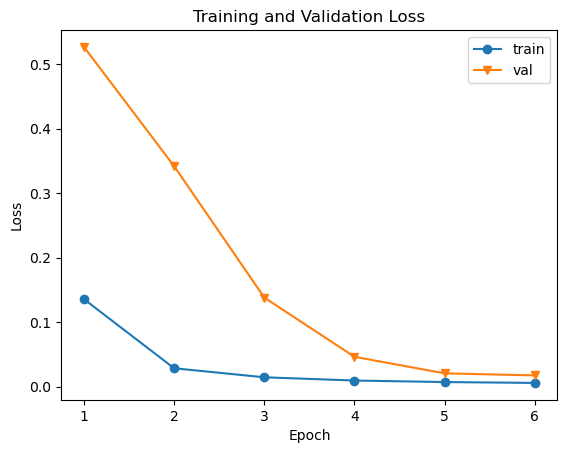

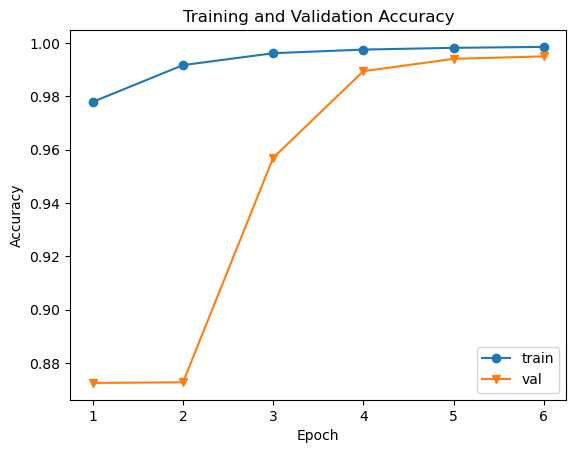


******* Evaluation started *******

108/108 [==============================] - 26s 234ms/step - loss: 0.0220 - accuracy: 0.9933

Test loss     : 0.0220
Test accuracy : 99.33%

******* Evaluation finished *******


INFO: Whole program executed for 20 mins 24 secs.


In [11]:
if __name__ == "__main__":
    
    start_time = time.time()
    
    main()
    
    end_time = time.time()

    minutes, seconds = divmod(end_time - start_time, 60)
    print("\n\nINFO: Whole program executed for", round(minutes), "mins", round(seconds), "secs.")